In [1]:
import akshare as ak
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams['font.sans-serif'] = ['AR PL UKai CN','Noto Sans Kaithi']
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

# 黄金 000218
# 短融 000128
# 长债  003376
# 30长债 010309
# 美债 004998
# 红利 161907
# 红利低波 005561
# 标普 161125
# 纳斯达克 160213


In [2]:
def merge_fund_data_by_date(*dataframes):
    """
    将多个基金数据根据日期合并，返回只有date和price两列的DataFrame
    price列为所有输入DataFrame的price列之和
    
    Parameters:
    *dataframes: 可变数量的DataFrame，每个都应包含'date'和'price'列
    
    Returns:
    DataFrame: 合并后的DataFrame，包含'date'和'price'两列
    """
    if not dataframes:
        raise ValueError("至少需要一个DataFrame")
    
    # 使用第一个DataFrame作为基础
    merged_df = dataframes[0][['date', 'price']].copy()
    merged_df.columns = ['date', 'price_0']  # 重命名避免冲突
    
    # 依次合并其他DataFrame，并给每列一个唯一名称
    for i, df in enumerate(dataframes[1:], 1):
        # 为避免列名冲突，给每个price列一个唯一名称
        temp_df = df[['date', 'price']].copy()
        temp_df.columns = ['date', f'price_{i}']
        merged_df = merged_df.merge(temp_df, on='date', how='inner')
    
    # 将所有price列相加
    price_columns = [col for col in merged_df.columns if col.startswith('price_')]
    merged_df['price'] = merged_df[price_columns].sum(axis=1)
    
    # 只保留date和price列
    return merged_df[['date', 'price']]

# 使用示例：
# d3_d4_d5_d6_merged = merge_fund_data_by_date(d3, d4, d5, d6)
def get_data():
    d1 = ak.fund_open_fund_info_em(symbol="000218", indicator="累计净值走势").rename(columns={'净值日期': 'date', '累计净值': 'price'})
    cash = ak.fund_open_fund_info_em(symbol="000128", indicator="累计净值走势").rename(columns={'净值日期': 'date', '累计净值': 'price'}) #现金储备不能改
    d2 = ak.fund_open_fund_info_em(symbol="003376", indicator="累计净值走势").rename(columns={'净值日期': 'date', '累计净值': 'price'})
    d3 = ak.fund_open_fund_info_em(symbol="161907", indicator="累计净值走势").rename(columns={'净值日期': 'date', '累计净值': 'price'})
    d4 = ak.fund_open_fund_info_em(symbol="161907", indicator="累计净值走势").rename(columns={'净值日期': 'date', '累计净值': 'price'})
    d5 = ak.fund_open_fund_info_em(symbol="005561", indicator="累计净值走势").rename(columns={'净值日期': 'date', '累计净值': 'price'})
    d6 = ak.fund_open_fund_info_em(symbol="005561", indicator="累计净值走势").rename(columns={'净值日期': 'date', '累计净值': 'price'})
    stock = merge_fund_data_by_date(d3, d4, d5, d6)
    dataframes = [d1, cash, d2, stock]
    merged_data = reduce(lambda left, right: left.merge(right, on='date', how='inner', suffixes=('', '_right')), dataframes)
    merged_data.columns = ['date', '黄金', '短融', '长债', '股票']
    merged_data['date'] = pd.to_datetime(merged_data['date'])
    return merged_data
merged_data = get_data()
start_year = 2018
start_month = 4
first_date = merged_data['date'].iloc[0]
if first_date.month == 12:
    start_year = first_date.year + 1
    start_month = 1
else:
    start_year = first_date.year
    start_month = first_date.month + 1
end_year = datetime.now().year
end_month = datetime.now().month
merged_data

,date,黄金,短融,长债,股票
0,2018-04-26,1.0313,1.2856,0.9688,5.1910
1,2018-04-27,1.0277,1.2854,0.9680,5.1964
2,2018-05-04,1.0245,1.2864,0.9708,5.2332
3,2018-05-11,1.0291,1.2872,0.9666,5.3182
4,2018-05-16,1.0150,1.2873,0.9644,5.3308
...,...,...,...,...,...
1827,2025-11-10,3.3778,1.5242,1.4541,10.0504
1828,2025-11-11,3.4222,1.5243,1.4546,10.0548
1829,2025-11-12,3.4153,1.5245,1.4554,10.0884
1830,2025-11-13,3.4656,1.5245,1.4554,10.0932


In [3]:
def analyze_etf_monthly_data(year, month):
    """
    分析指定年月的ETF数据并计算风险比例和相关系数
    
    Parameters:
    year (int): 年份
    month (int): 月份
    
    Returns:
    tuple: (risk_contribution, correlation_matrix)
    """
    merged_data = get_data()
    
    mask = (merged_data['date'].dt.year == year) & (merged_data['date'].dt.month == month)
    monthly_data = merged_data.loc[mask].copy() 
    
    if monthly_data.empty:
        print(f"警告: {year}年{month}月没有找到数据")
        return None, None
    
    etf_columns = ['黄金', '短融', '长债', '股票']
    for col in etf_columns:
        monthly_data.loc[:, f'{col}_pct'] = monthly_data.loc[:, col].pct_change(fill_method=None) * 100
    
    pct_columns = ['黄金_pct', '短融_pct', '长债_pct', '股票_pct']
    etf_data = monthly_data.loc[:, pct_columns]
    etf_data = etf_data.dropna()
    
    # 检查是否有足够的数据
    if etf_data.empty:
        print(f"警告: {year}年{month}月数据不足，无法计算统计指标")
        return None, None
    
    # 计算波动率和风险比例
    volatility = etf_data.std() * np.sqrt(252)  # 年化波动率
    total_volatility = volatility.sum()
    risk_contribution = volatility / total_volatility * 100
    
    return risk_contribution, etf_data.corr()

def get_etf_analysis_period(start_year, start_month, end_year, end_month):
    """
    获取指定时间段内每月的ETF风险比例和相关系数矩阵
    
    Parameters:
    start_year (int): 开始年份
    start_month (int): 开始月份
    end_year (int): 结束年份
    end_month (int): 结束月份
    
    Returns:
    dict: 包含每月风险比例和相关系数矩阵的字典
    """
    results = {}
    
    # 遍历时间段内的所有月份
    current_year = start_year
    current_month = start_month
    
    while (current_year < end_year) or (current_year == end_year and current_month <= end_month):
        try:
            risk_ratio, corr_matrix = analyze_etf_monthly_data(current_year, current_month)
            if risk_ratio is not None and corr_matrix is not None:
                results[f"{current_year}-{current_month:02d}"] = {
                    'risk_ratio': risk_ratio,
                    'corr_matrix': corr_matrix
                }
            else:
                print(f"{current_year}年{current_month:02d}月 数据不足或不存在")
        except Exception as e:
            print(f"处理 {current_year}年{current_month:02d}月 数据时出错: {e}")
        
        # 移动到下一个月
        current_month += 1
        if current_month > 12:
            current_month = 1
            current_year += 1
    
    return results

In [4]:
def print_summary_statistics(results):
    """
    打印汇总统计信息
    """
    if not results:
        print("没有数据可供统计")
        return
    
    # 准备数据
    dates = sorted(list(results.keys()))
    etf_names = list(results[list(results.keys())[0]]['risk_ratio'].index)
    
    # 定义时间段
    periods = {
        "近1个月": 1,
        "近3个月": 3,
        "近半年": 6,
        "近1年": 12,
        "近3年": 36,
        "从最早到目前为止": len(dates)
    }
    
    # 按时间段计算和打印统计信息
    for period_name, months in periods.items():
        # 确定时间段内的数据
        if months >= len(dates):
            period_dates = dates  # 使用所有数据
        else:
            # 计算起始索引
            start_index = max(0, len(dates) - months)
            period_dates = dates[start_index:]
        
        if not period_dates:
            print(f"\n{period_name}: 没有数据")
            continue
            
        # 计算平均风险比例
        avg_risk_data = {}
        for etf in etf_names:
            avg_risk_data[etf] = sum([results[date]['risk_ratio'][etf] for date in period_dates]) / len(period_dates)
        
        print(f"\n{period_name} ({period_dates[0]} 到 {period_dates[-1]}):")
        print("  平均风险比例:")
        for etf, ratio in avg_risk_data.items():
            print(f"    {etf}: {ratio:.4f}")
        
        if months <= 6:
            continue
        # 计算中位数风险比例
        median_risk_data = {}
        for etf in etf_names:
            risk_values = [results[date]['risk_ratio'][etf] for date in period_dates]
            risk_values.sort()
            n = len(risk_values)
            if n % 2 == 0:
                median_risk_data[etf] = (risk_values[n//2 - 1] + risk_values[n//2]) / 2
            else:
                median_risk_data[etf] = risk_values[n//2]
        
        print("  中位数风险比例:")
        for etf, ratio in median_risk_data.items():
            print(f"    {etf}: {ratio:.4f}")
        
def visualize_risk_ratios(results):
    """
    可视化风险比例变化趋势
    """
    if not results:
        print("没有数据可供可视化")
        return
    
    # 准备数据
    dates = list(results.keys())
    etf_names = list(results[list(results.keys())[0]]['risk_ratio'].index)
    
    # 创建DataFrame存储风险比例数据
    risk_data = {}
    for etf in etf_names:
        risk_data[etf] = [results[date]['risk_ratio'][etf] for date in dates]
    
    risk_df = pd.DataFrame(risk_data, index=dates)
    
    # 绘制风险比例变化图
    plt.figure(figsize=(24, 8))
    for etf in etf_names:
        plt.plot(risk_df.index, risk_df[etf], marker='o', label=etf, linewidth=2)
    
    plt.title('各ETF风险比例月度变化趋势', fontsize=16)
    plt.xlabel('月份', fontsize=12)
    plt.ylabel('风险比例', fontsize=12)
    plt.legend()
    plt.xticks(rotation=65)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [5]:
def calculate_portfolio_drawdown_and_recovery(merged_data, weights):
    """
    计算给定权重的投资组合的最大回撤和回撤修复时间
    
    Parameters:
    merged_data (DataFrame): 包含各资产净值数据的DataFrame
    weights (dict): 各资产的权重配置
    
    Returns:
    tuple: (最大回撤, 回撤开始日期, 回撤结束日期, 修复日期, 修复月数)
    """
    # 计算组合净值
    portfolio_value = pd.Series(0, index=merged_data.index)
    
    # 归一化初始价格，使所有资产起始值为1
    for asset in weights.keys():
        normalized_prices = merged_data[asset] / merged_data[asset].iloc[0]
        portfolio_value += normalized_prices * weights[asset]
    
    # 创建组合数据DataFrame
    portfolio_df = pd.DataFrame({
        'date': merged_data['date'],
        'value': portfolio_value
    })
    
    # 按日期排序
    portfolio_df = portfolio_df.sort_values('date').reset_index(drop=True)
    
    # 计算累积净值序列的峰值
    portfolio_df['peak'] = portfolio_df['value'].expanding(min_periods=1).max()
    
    # 计算回撤
    portfolio_df['drawdown'] = (portfolio_df['value'] - portfolio_df['peak']) / portfolio_df['peak']
    
    # 找到最大回撤的位置
    max_drawdown_idx = portfolio_df['drawdown'].idxmin()
    max_drawdown = portfolio_df.loc[max_drawdown_idx, 'drawdown']
    
    # 获取最大回撤的日期信息
    max_drawdown_date = portfolio_df.loc[max_drawdown_idx, 'date']
    
    # 找到回撤开始前的峰值日期
    peak_value = portfolio_df.loc[max_drawdown_idx, 'peak']
    # peak_idx = portfolio_df[portfolio_df['date'] <= max_drawdown_date][portfolio_df['value'] == peak_value].index[-1]
    mask = (portfolio_df['date'] <= max_drawdown_date) & (portfolio_df['value'] == peak_value)
    peak_idx = portfolio_df[mask].index[-1]
    peak_date = portfolio_df.loc[peak_idx, 'date']
    
    # 计算修复时间
    recovery_idx = None
    recovery_date = None
    recovery_months = None
    
    # 寻找回撤修复日期（净值重新达到峰值）
    for idx in range(max_drawdown_idx + 1, len(portfolio_df)):
        if portfolio_df.loc[idx, 'value'] >= peak_value:
            recovery_idx = idx
            recovery_date = portfolio_df.loc[idx, 'date']
            # 计算月份数
            months = (recovery_date.year - peak_date.year) * 12 + (recovery_date.month - peak_date.month)
            recovery_months = months
            break
    
    return max_drawdown, peak_date, max_drawdown_date, recovery_date, recovery_months

def calculate_max_drawdown_and_recovery(data, asset_column):
    """
    计算最大回撤和回撤修复时间
    
    Parameters:
    data (DataFrame): 包含日期和资产净值的数据
    asset_column (str): 资产列名
    
    Returns:
    tuple: (最大回撤, 回撤开始日期, 回撤结束日期, 修复日期, 修复月数)
    """
    # 确保数据按日期排序
    df = data[['date', asset_column]].copy()
    df = df.sort_values('date').reset_index(drop=True)
    
    # 计算累积净值序列的峰值
    df['peak'] = df[asset_column].expanding(min_periods=1).max()
    
    # 计算回撤
    df['drawdown'] = (df[asset_column] - df['peak']) / df['peak']
    
    # 找到最大回撤的位置
    max_drawdown_idx = df['drawdown'].idxmin()
    max_drawdown = df.loc[max_drawdown_idx, 'drawdown']
    
    # 获取最大回撤的日期信息
    max_drawdown_date = df.loc[max_drawdown_idx, 'date']
    
    # 找到回撤开始前的峰值日期
    peak_value = df.loc[max_drawdown_idx, 'peak']
    mask = (df['date'] <= max_drawdown_date) & (df[asset_column] == peak_value)
    peak_idx = df[mask].index[-1]
    peak_date = df.loc[peak_idx, 'date']
    
    # 计算修复时间
    recovery_idx = None
    recovery_date = None
    recovery_months = None
    
    # 寻找回撤修复日期（净值重新达到峰值）
    for idx in range(max_drawdown_idx + 1, len(df)):
        if df.loc[idx, asset_column] >= peak_value:
            recovery_idx = idx
            recovery_date = df.loc[idx, 'date']
            # 计算月份数
            months = (recovery_date.year - peak_date.year) * 12 + (recovery_date.month - peak_date.month)
            recovery_months = months
            break
    
    return max_drawdown, peak_date, max_drawdown_date, recovery_date, recovery_months


# 绘制组合回撤曲线图
def plot_portfolio_drawdown(merged_data, weights):
    """
    绘制投资组合的回撤曲线
    """
    # 计算组合净值
    portfolio_value = pd.Series(0, index=merged_data.index)
    
    # 归一化初始价格，使所有资产起始值为1
    for asset in weights.keys():
        normalized_prices = merged_data[asset] / merged_data[asset].iloc[0]
        portfolio_value += normalized_prices * weights[asset]
    
    # 创建组合数据DataFrame
    portfolio_df = pd.DataFrame({
        'date': merged_data['date'],
        'value': portfolio_value
    })
    
    # 按日期排序
    portfolio_df = portfolio_df.sort_values('date').reset_index(drop=True)
    
    # 计算累积净值序列的峰值和回撤
    portfolio_df['peak'] = portfolio_df['value'].expanding(min_periods=1).max()
    portfolio_df['drawdown'] = (portfolio_df['value'] - portfolio_df['peak']) / portfolio_df['peak']
    
    # 绘制图形
    plt.figure(figsize=(14, 10))
    
    # 子图1: 组合净值走势
    plt.subplot(2, 1, 1)
    plt.plot(portfolio_df['date'], portfolio_df['value'], color='purple', linewidth=2, label='组合净值')
    plt.plot(portfolio_df['date'], portfolio_df['peak'], color='green', linestyle='--', linewidth=1, label='历史峰值')
    plt.title('投资组合净值走势', fontsize=14)
    plt.ylabel('净值')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 标注最大回撤点
    max_dd_idx = portfolio_df['drawdown'].idxmin()
    max_dd_value = portfolio_df.loc[max_dd_idx, 'drawdown']
    max_dd_date = portfolio_df.loc[max_dd_idx, 'date']
    max_dd_nav = portfolio_df.loc[max_dd_idx, 'value']
    peak_value = portfolio_df.loc[max_dd_idx, 'peak']
    
    plt.scatter(max_dd_date, max_dd_nav, color='red', s=80, zorder=5)
    plt.annotate(f'最大回撤点\n{max_dd_value*100:.2f}%', 
                xy=(max_dd_date, max_dd_nav), 
                xytext=(20, 20), 
                textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    # 子图2: 回撤曲线
    plt.subplot(2, 1, 2)
    plt.plot(portfolio_df['date'], portfolio_df['drawdown'], color='red', linewidth=2)
    plt.fill_between(portfolio_df['date'], portfolio_df['drawdown'], 0, color='red', alpha=0.3)
    plt.title('投资组合回撤曲线', fontsize=14)
    plt.ylabel('回撤 (%)')
    plt.xlabel('日期')
    plt.grid(True, alpha=0.3)
    
    # 标注最大回撤点
    plt.scatter(max_dd_date, max_dd_value, color='darkred', s=80, zorder=5)
    plt.annotate(f'最大回撤\n{max_dd_value*100:.2f}%', 
                xy=(max_dd_date, max_dd_value), 
                xytext=(20, -20), 
                textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    plt.tight_layout()
    plt.show()
    
    return portfolio_df


开始分析2018年5月至2025年11月的ETF数据...

近1个月 (2025-11 到 2025-11):
  平均风险比例:
    黄金_pct: 74.1406
    短融_pct: 0.6679
    长债_pct: 4.1877
    股票_pct: 21.0038

近3个月 (2025-09 到 2025-11):
  平均风险比例:
    黄金_pct: 69.7797
    短融_pct: 0.8267
    长债_pct: 5.7894
    股票_pct: 23.6041

近半年 (2025-06 到 2025-11):
  平均风险比例:
    黄金_pct: 60.1862
    短融_pct: 0.8527
    长债_pct: 8.1594
    股票_pct: 30.8018

近1年 (2024-12 到 2025-11):
  平均风险比例:
    黄金_pct: 55.4039
    短融_pct: 1.0460
    长债_pct: 10.4979
    股票_pct: 33.0523
  中位数风险比例:
    黄金_pct: 54.5869
    短融_pct: 0.9991
    长债_pct: 10.5677
    股票_pct: 33.0857

近3年 (2022-12 到 2025-11):
  平均风险比例:
    黄金_pct: 48.1801
    短融_pct: 1.0247
    长债_pct: 7.9197
    股票_pct: 42.8755
  中位数风险比例:
    黄金_pct: 50.1203
    短融_pct: 0.9627
    长债_pct: 6.9585
    股票_pct: 38.9014

从最早到目前为止 (2018-05 到 2025-11):
  平均风险比例:
    黄金_pct: 41.9796
    短融_pct: 0.8672
    长债_pct: 7.3881
    股票_pct: 49.7652
  中位数风险比例:
    黄金_pct: 43.5638
    短融_pct: 0.7314
    长债_pct: 6.3895
    股票_pct: 49.2672


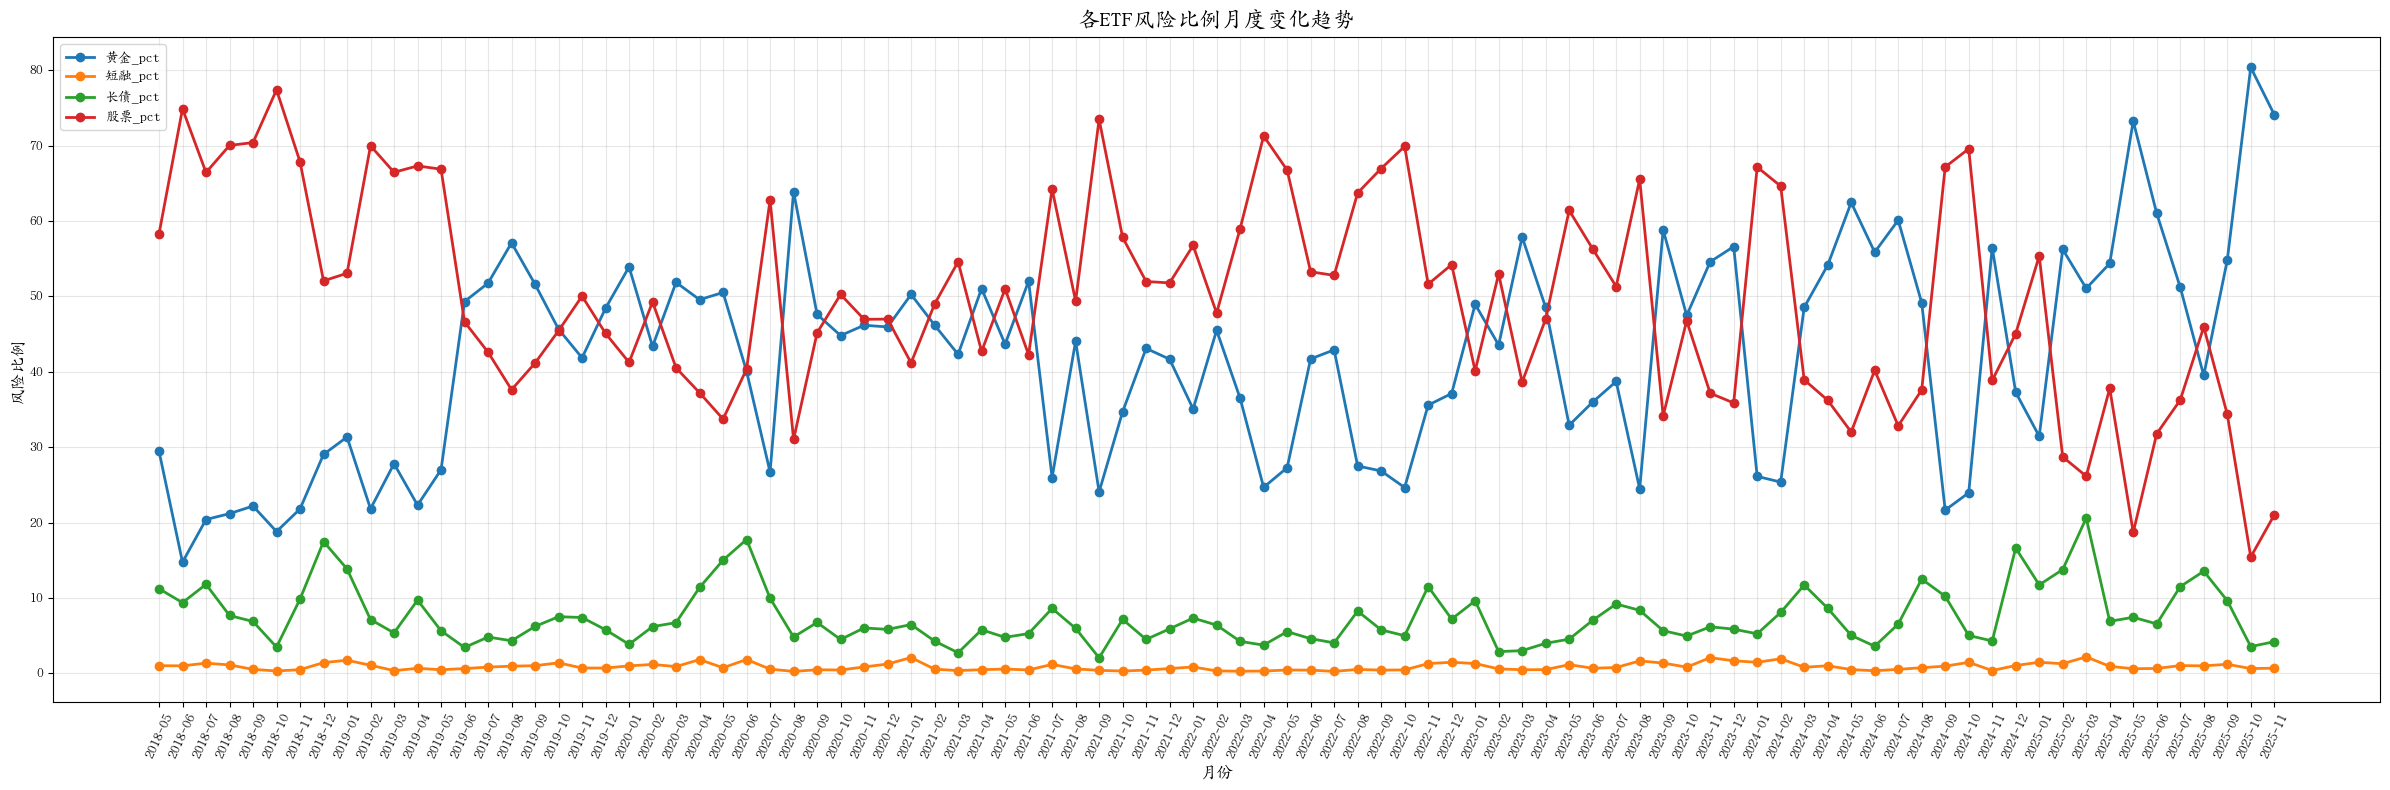

指定权重组合的最大回撤及修复时间分析
组合权重配置:
  短融: 25.0%
  长债: 25.0%
  黄金: 25.0%
  股票: 25.0%

分析结果:
  最大回撤: -5.24%
  回撤开始日期(峰值): 2020-03-06
  最大回撤日期: 2020-03-19
  回撤修复日期: 2020-04-30
  修复时间: 1 个月


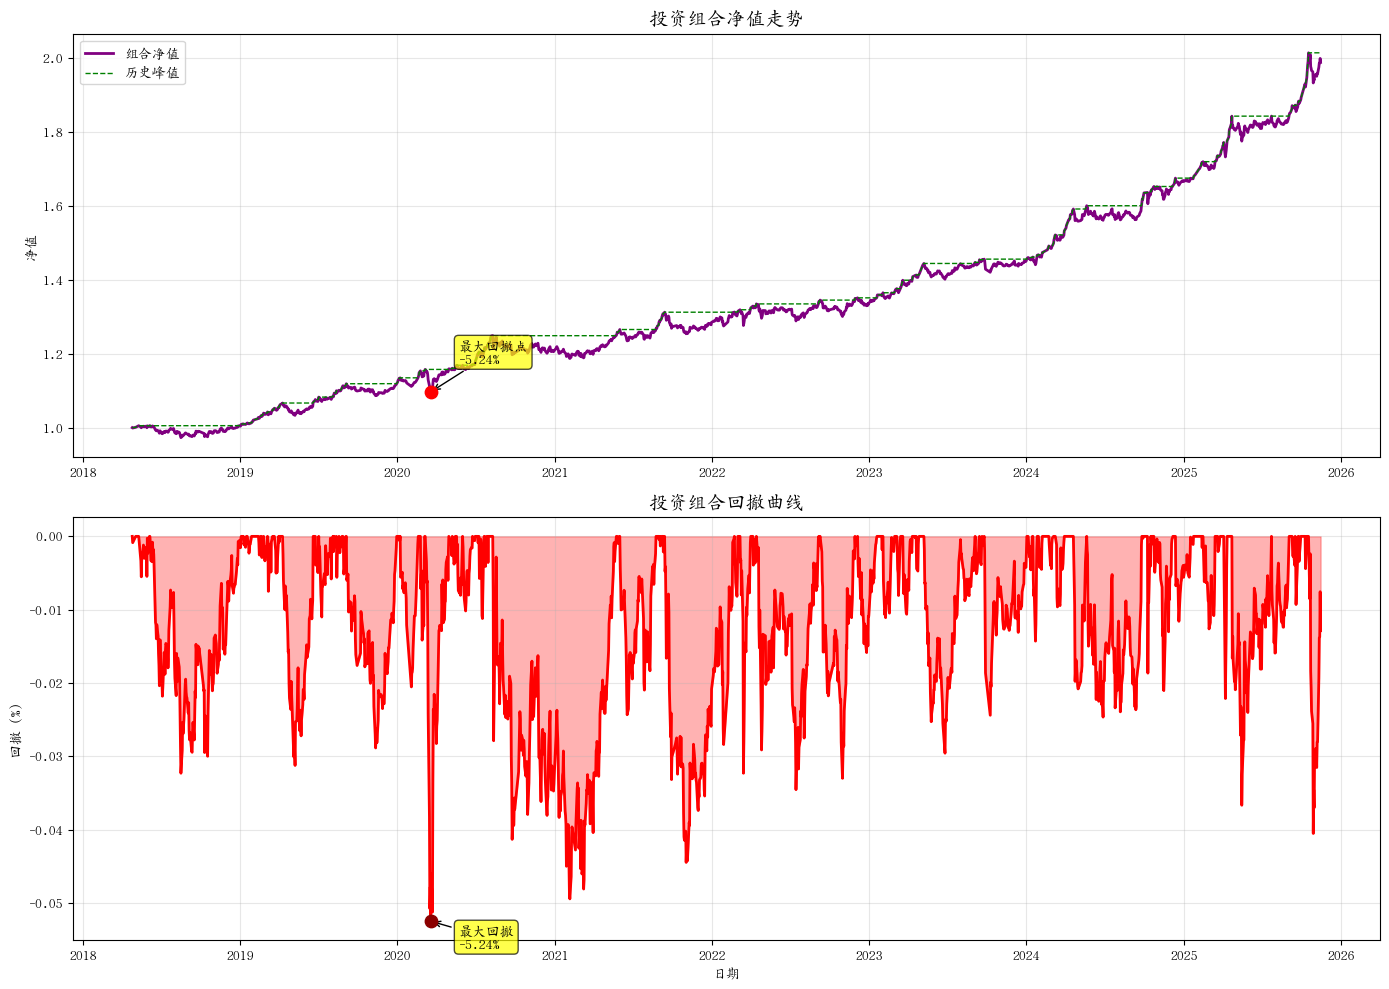


组合与各单项资产最大回撤对比
资产         最大回撤       修复时间      
------------------------------
黄金            -20.62% 33个月      
短融             -0.29% 2个月       
长债             -5.06% 15个月      
股票            -18.84% 10个月      
组合             -5.24% 1         

风险分散效果:
  各资产平均最大回撤: 11.20%
  组合最大回撤: 5.24%
  风险降低幅度: 53.19%


In [6]:
print(f"开始分析{start_year}年{start_month}月至{end_year}年{end_month}月的ETF数据...")
results = get_etf_analysis_period(start_year, start_month, end_year, end_month)
print_summary_statistics(results)
visualize_risk_ratios(results)
# 定义资产权重
portfolio_weights = {
    '短融': 0.25,
    '长债': 0.25,
    '黄金': 0.25,
    '股票': 0.25,
}

# 计算组合最大回撤和修复时间
try:
    max_dd, peak_date, dd_date, recovery_date, recovery_months = calculate_portfolio_drawdown_and_recovery(
        merged_data, portfolio_weights
    )
    
    print("="*60)
    print("指定权重组合的最大回撤及修复时间分析")
    print("="*60)
    print("组合权重配置:")
    for asset, weight in portfolio_weights.items():
        print(f"  {asset}: {weight*100:.1f}%")
    print()
    print("分析结果:")
    print(f"  最大回撤: {max_dd*100:.2f}%")
    print(f"  回撤开始日期(峰值): {peak_date.strftime('%Y-%m-%d')}")
    print(f"  最大回撤日期: {dd_date.strftime('%Y-%m-%d')}")
    
    if recovery_date:
        print(f"  回撤修复日期: {recovery_date.strftime('%Y-%m-%d')}")
        print(f"  修复时间: {recovery_months} 个月")
    else:
        print("  回撤修复日期: 尚未修复")
        # 计算至今的修复时间
        last_date = merged_data['date'].max()
        months_since_peak = (last_date.year - peak_date.year) * 12 + (last_date.month - peak_date.month)
        print(f"  至今修复时间: {months_since_peak} 个月 (尚未完全修复)")

except Exception as e:
    print(f"计算组合回撤时出现错误: {e}")
# 绘制组合回撤曲线
portfolio_df = plot_portfolio_drawdown(merged_data, portfolio_weights)

# 与各单项资产回撤对比
print("\n" + "="*60)
print("组合与各单项资产最大回撤对比")
print("="*60)

# 计算并显示各单项资产的回撤
individual_drawdowns = {}
assets = ['黄金', '短融', '长债', '股票']

print(f"{'资产':<10} {'最大回撤':<10} {'修复时间':<10}")
print("-" * 30)
for asset in assets:
    max_dd, _, _, _, recovery_months = calculate_max_drawdown_and_recovery(merged_data, asset)
    individual_drawdowns[asset] = abs(max_dd)
    recovery_text = f"{recovery_months}个月" if recovery_months else "未修复"
    print(f"{asset:<10} {max_dd*100:>9.2f}% {recovery_text:<10}")

# 计算组合回撤
max_dd, peak_date, dd_date, recovery_date, recovery_months = calculate_portfolio_drawdown_and_recovery(merged_data, portfolio_weights)
portfolio_max_dd = max_dd
print(f"{'组合':<10} {portfolio_max_dd*100:>9.2f}% {recovery_months if recovery_months else '未修复':<10}")

# 计算风险降低效果
avg_individual_drawdown = np.mean(list(individual_drawdowns.values()))
risk_reduction = (avg_individual_drawdown - abs(portfolio_max_dd)) / avg_individual_drawdown * 100

print(f"\n风险分散效果:")
print(f"  各资产平均最大回撤: {avg_individual_drawdown*100:.2f}%")
print(f"  组合最大回撤: {abs(portfolio_max_dd)*100:.2f}%")
print(f"  风险降低幅度: {risk_reduction:.2f}%")

# 简单回测

# 原始方法

In [7]:
import pandas as pd

def backtest_new_method(start_year, start_month, price_per_month, M, initial_capital=100000):
    """
    每月先补短融到25%，剩余资金投入其余3个资产中仓位最低的资产。
    每月额外打印：每个资产相对成本的收益率。
    """

    df = get_data().copy()
    df['date'] = pd.to_datetime(df['date'])

    start_ts = pd.Timestamp(start_year, start_month, 1)
    df = df[df['date'] >= start_ts].sort_values("date").reset_index(drop=True)

    # 月末价格
    df_m = df.set_index("date").resample("M").last().reset_index()
    assets = ['黄金', '短融', '长债', '股票']

    if len(df_m) < M + 1:
        raise ValueError(f"数据不足，需要至少 {M+1} 个月。")

    # ===============================
    # 初始建仓
    # ===============================
    cost = {a: 0.0 for a in assets}
    units = {a: 0.0 for a in assets}

    first_prices = df_m.loc[0, assets]
    print(f"\n======= 第 0 月初始建仓 ({df_m.loc[0,'date'].date()}) =======")

    for a in assets:
        allocation = initial_capital * 0.25
        buy_units = allocation / first_prices[a]
        units[a] += buy_units
        cost[a] += allocation
        print(f"初始买入 {a}: 金额={allocation:.2f}, 价格={first_prices[a]:.4f}, 份额={buy_units:.4f}")

    def portfolio_value(idx):
        return sum(units[a] * df_m.loc[idx, a] for a in assets)

    # ===============================
    # 月度循环
    # ===============================
    for i in range(1, M + 1):
        date_str = df_m.loc[i, "date"].date()
        invest = float(price_per_month)
        print(f"\n======= 第 {i} 月 ({date_str}) =======")

        operations = []

        total_prev = portfolio_value(i - 1)

        # ------------------------------
        # Step 1：补短融到 25%
        # ------------------------------
        short_price = df_m.loc[i, '短融']
        short_value = units['短融'] * short_price

        need_short = max(0.0, 0.25 * total_prev - short_value)

        if need_short > 0 and invest > 0:
            alloc = min(invest, need_short)
            buy_units = alloc / short_price
            units['短融'] += buy_units
            cost['短融'] += alloc
            invest -= alloc
            operations.append(
                f"补仓短融: 投入={alloc:.2f}, 价格={short_price:.4f}, 份额={buy_units:.4f}"
            )

        # ------------------------------
        # Step 2：剩余资金 → 仓位最低资产
        # ------------------------------
        if invest > 0:
            total_now_tmp = portfolio_value(i)

            weights = {
                a: (units[a] * df_m.loc[i, a] / total_now_tmp) if total_now_tmp else 0
                for a in assets
            }

            candidates = [a for a in assets if a != '短融']
            target = min(candidates, key=lambda a: weights[a])

            target_price = df_m.loc[i, target]
            alloc = invest
            buy_units = alloc / target_price
            units[target] += buy_units
            cost[target] += alloc
            invest = 0.0

            operations.append(
                f"买入仓位最低资产 {target}: 投入={alloc:.2f}, 价格={target_price:.4f}, 份额={buy_units:.4f}"
            )

        # ------------------------------
        # 打印本月交易
        # ------------------------------
        if operations:
            print("本月交易行为：")
            for op in operations:
                print("  - " + op)
        else:
            print("本月无交易。")

        # ------------------------------
        # 本月各资产“相对成本收益率”
        # ------------------------------
        print("\n本月各资产收益率（相对成本）：")
        for a in assets:
            if cost[a] > 0:
                current_value = units[a] * df_m.loc[i, a]
                r = (current_value / cost[a]) - 1
                print(f"  - {a}: {r:.2%}")
            else:
                print(f"  - {a}: N/A (无成本)")

        # ------------------------------
        # 本月资产情况
        # ------------------------------
        total_now = portfolio_value(i)
        total_cost = sum(cost.values())

        print("\n本月资产情况：")
        for a in assets:
            value = units[a] * df_m.loc[i, a]
            pct = value / total_now if total_now else 0
            print(f"{a}: 成本={cost[a]:.2f}, 市值={value:.2f}, 占比={pct:.2%}")

        print(f"总投入={total_cost:.2f}, 总市值={total_now:.2f}, "
              f"收益率={(total_now/total_cost - 1):.2%}")

    # ===============================
    # 年化收益率
    # ===============================
    final_val = portfolio_value(M)
    total_cost = sum(cost.values())
    annualized = (final_val / total_cost) ** (12 / M) - 1

    print(f"\n======= 回测完成，累计 {M} 月，年化收益率 = {annualized:.2%} =======")
    return annualized


In [8]:
annualized = backtest_new_method(
    start_year=start_year,
    start_month=end_month-1,
    price_per_month=10000,
    M=12*(end_year-start_year),
    initial_capital=150000
)



======= 第 0 月初始建仓 (2018-10-31) =======
初始买入 黄金: 金额=37500.00, 价格=1.0366, 份额=36175.9599
初始买入 短融: 金额=37500.00, 价格=1.3083, 份额=28663.1507
初始买入 长债: 金额=37500.00, 价格=1.0120, 份额=37055.3360
初始买入 股票: 金额=37500.00, 价格=4.5380, 份额=8263.5522

======= 第 1 月 (2018-11-30) =======
本月交易行为：
  - 买入仓位最低资产 黄金: 投入=10000.00, 价格=1.0383, 份额=9631.1278

本月各资产收益率（相对成本）：
  - 黄金: 0.13%
  - 短融: 0.23%
  - 长债: 1.63%
  - 股票: 0.93%

本月资产情况：
黄金: 成本=47500.00, 市值=47561.50, 占比=29.52%
短融: 成本=37500.00, 市值=37585.99, 占比=23.33%
长债: 成本=37500.00, 市值=38111.41, 占比=23.66%
股票: 成本=37500.00, 市值=37847.07, 占比=23.49%
总投入=160000.00, 总市值=161105.97, 收益率=0.69%

======= 第 2 月 (2018-12-31) =======
本月交易行为：
  - 补仓短融: 投入=2618.85, 价格=1.3138, 份额=1993.3364
  - 买入仓位最低资产 股票: 投入=7381.15, 价格=4.5560, 份额=1620.0954

本月各资产收益率（相对成本）：
  - 黄金: 3.62%
  - 短融: 0.39%
  - 长债: 3.25%
  - 股票: 0.33%

本月资产情况：
黄金: 成本=47500.00, 市值=49219.72, 占比=28.41%
短融: 成本=40118.85, 市值=40276.49, 占比=23.25%
长债: 成本=37500.00, 市值=38719.12, 占比=22.35%
股票: 成本=44881.15, 市值=45029.90, 占比=25.99%
总投入=1700

/tmp/ipykernel_8720/3269461360.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_m = df.set_index("date").resample("M").last().reset_index()


# 我的方法

In [9]:
def backtest_investment(year, month, months, price=1000, 
                       weights={'黄金': 0.25, '短融': 0.25, '长债': 0.25, 
                               '股票': 0.25}, upper_threshold=0.35, lower_threshold=0.15):
    """
    定投回测函数
    
    Parameters:
    year (int): 开始年份
    month (int): 开始月份
    months (int): 定投月数
    price (float): 每月定投金额
    weights (dict): 各组合的投资比例
    
    Returns:
    dict: 回测结果
    """
    
    # 获取数据
    data = get_data()
    
    # 初始化投资记录
    assets = ['黄金', '短融', '长债', '股票']
    holdings = {asset: {'shares': 0, 'cost': 0} for asset in assets}
    
    # 记录每月情况
    monthly_records = []
    
    # 开始时间
    current_year = year
    current_month = month
    
    for m in range(months):
        # 获取当月第一个交易日
        month_data = data[(data['date'].dt.year == current_year) & 
                         (data['date'].dt.month == current_month)]
        
        if month_data.empty:
            print(f"警告: {current_year}年{current_month}月没有交易数据")
            # 移动到下个月
            current_month += 1
            if current_month > 12:
                current_month = 1
                current_year += 1
            continue
        
        first_day = month_data.iloc[0]
        last_day = month_data.iloc[-1]
        
        print(f"\n第{m+1}月: {current_year}年{current_month}月 (第一个交易日: {first_day['date'].strftime('%Y-%m-%d')})")
        print("-" * 80)
        
        # 检查上月跌幅（用于加仓策略） - 在定投之前执行
        if m > 0:
            prev_month = current_month - 1 if current_month > 1 else 12
            prev_year = current_year if current_month > 1 else current_year - 1
            prev_month_data = data[(data['date'].dt.year == prev_year) & 
                                  (data['date'].dt.month == prev_month)]
            
            if not prev_month_data.empty and len(prev_month_data) > 0:
                prev_first_day = prev_month_data.iloc[0]
                prev_last_day = prev_month_data.iloc[-1]
                
                # 先收集所有需要加仓的资产信息
                buy_list = []
                for asset in assets:
                    if asset == '短融':  # 短融不参与加仓
                        continue
                    
                    decline = (prev_last_day[asset] - prev_first_day[asset]) / prev_first_day[asset]
                    buy_ratio = 0
                    
                    # 根据跌幅确定加仓比例
                    if decline <= -0.20:
                        buy_ratio = 1.0
                    elif decline <= -0.15:
                        buy_ratio = 0.75
                    elif decline <= -0.10:
                        buy_ratio = 0.5
                    elif decline <= -0.05:
                        buy_ratio = 0.25
                    
                    if buy_ratio > 0:
                        buy_list.append({
                            'asset': asset,
                            'decline': decline,
                            'buy_ratio': buy_ratio,
                            'nav': first_day[asset]
                        })
                
                # 按跌幅从大到小排序，优先加仓跌幅大的
                buy_list.sort(key=lambda x: x['decline'])
                
                # 执行加仓，每次都基于初始余额计算
                if buy_list and holdings['短融']['shares'] > 0:
                    # 计算短融当前可用市值
                    available_value = holdings['短融']['shares'] * first_day['短融']
                    print(f"\n【加仓操作】短融可用市值: {available_value:.2f}元 (持有份额: {holdings['短融']['shares']:.4f})")
                    
                    initial_available = available_value
                    for buy_info in buy_list:
                        if holdings['短融']['shares'] > 0:
                            # 基于初始可用市值计算应该使用的金额
                            buy_amount = initial_available * buy_info['buy_ratio']
                            # 但不能超过当前剩余市值
                            current_available = holdings['短融']['shares'] * first_day['短融']
                            buy_amount = min(buy_amount, current_available)
                            
                            # 计算需要卖出的短融份额
                            sell_shares = buy_amount / first_day['短融']
                            
                            # 卖出短融
                            holdings['短融']['shares'] -= sell_shares
                            holdings['短融']['cost'] -= buy_amount  # 减少短融的成本
                            
                            # 买入目标资产
                            shares = buy_amount / buy_info['nav']
                            holdings[buy_info['asset']]['shares'] += shares
                            holdings[buy_info['asset']]['cost'] += buy_amount  # 增加目标资产的成本
                            
                            print(f"  加仓: {buy_info['asset']} 上月下跌 {buy_info['decline']*100:.2f}%, "
                                  f"卖出短融 {sell_shares:.4f}份({buy_amount:.2f}元), 购买 {shares:.4f}份")
                    
                    remaining_value = holdings['短融']['shares'] * first_day['短融']
                    print(f"  加仓后短融剩余: {holdings['短融']['shares']:.4f}份, 市值 {remaining_value:.2f}元\n")
        
        # 常规定投
        for asset in assets:
            invest_amount = price * weights[asset]
            nav = first_day[asset]
            shares = invest_amount / nav
            
            holdings[asset]['shares'] += shares
            holdings[asset]['cost'] += invest_amount
            
            print(f"  定投: {asset} 投资 {invest_amount:.2f}元, 净值 {nav:.4f}, 购买 {shares:.4f}份")
        
        print(f"\n  短融当前持有: {holdings['短融']['shares']:.4f}份, 市值 {holdings['短融']['shares'] * first_day['短融']:.2f}元")
        
        # 计算当前收益
        print(f"\n  当月末资产情况 ({last_day['date'].strftime('%Y-%m-%d')}):")
        total_cost = 0
        total_value = 0
        
        for asset in assets:
            cost = holdings[asset]['cost']
            shares = holdings[asset]['shares']
            current_nav = last_day[asset]
            value = shares * current_nav
            profit = value - cost
            profit_rate = (profit / cost * 100) if cost > 0 else 0
            
            total_cost += cost
            total_value += value
            
            print(f"    {asset}: 持有 {shares:.4f}份, 成本 {cost:.2f}元, "
                f"市值 {value:.2f}元, 收益 {profit:.2f}元 ({profit_rate:+.2f}%)")
        
        total_profit = total_value - total_cost
        total_profit_rate = (total_profit / total_cost * 100) if total_cost > 0 else 0
        
        print(f"\n  总计: 成本 {total_cost:.2f}元, 市值 {total_value:.2f}元, "
              f"收益 {total_profit:.2f}元 ({total_profit_rate:+.2f}%)")
        
        # 记录
        monthly_records.append({
            'month': m + 1,
            'date': last_day['date'],
            'total_cost': total_cost,
            'total_value': total_value,
            'total_profit': total_profit,
            'profit_rate': total_profit_rate
        })
        
        # 移动到下个月
        current_month += 1
        if current_month > 12:
            current_month = 1
            current_year += 1
    
    # 计算年化收益率
    if monthly_records:
        final_record = monthly_records[-1]
        years = months / 12
        annualized_return = (((final_record['total_value'] / final_record['total_cost']) ** (1/years)) - 1) * 100
        
        print("\n" + "=" * 80)
        print("回测总结")
        print("=" * 80)
        print(f"定投时长: {months}个月")
        print(f"总投入: {final_record['total_cost']:.2f}元")
        print(f"最终市值: {final_record['total_value']:.2f}元")
        print(f"总收益: {final_record['total_profit']:.2f}元")
        print(f"累计收益率: {final_record['profit_rate']:.2f}%")
        print(f"年化收益率: {annualized_return:.2f}%")
        
        return {
            'monthly_records': monthly_records,
            'holdings': holdings,
            'annualized_return': annualized_return,
            'total_profit_rate': final_record['profit_rate']
        }
    
    return None

In [10]:
res = backtest_investment(year=start_year, month=end_month-1, months=12*(end_year-start_year), price=10000)


第1月: 2018年10月 (第一个交易日: 2018-10-08)
--------------------------------------------------------------------------------
  定投: 黄金 投资 2500.00元, 净值 1.0111, 购买 2472.5546份
  定投: 短融 投资 2500.00元, 净值 1.3062, 购买 1913.9489份
  定投: 长债 投资 2500.00元, 净值 1.0003, 购买 2499.2502份
  定投: 股票 投资 2500.00元, 净值 4.7346, 购买 528.0277份

  短融当前持有: 1913.9489份, 市值 2500.00元

  当月末资产情况 (2018-10-31):
    黄金: 持有 2472.5546份, 成本 2500.00元, 市值 2563.05元, 收益 63.05元 (+2.52%)
    短融: 持有 1913.9489份, 成本 2500.00元, 市值 2504.02元, 收益 4.02元 (+0.16%)
    长债: 持有 2499.2502份, 成本 2500.00元, 市值 2529.24元, 收益 29.24元 (+1.17%)
    股票: 持有 528.0277份, 成本 2500.00元, 市值 2396.19元, 收益 -103.81元 (-4.15%)

  总计: 成本 10000.00元, 市值 9992.50元, 收益 -7.50元 (-0.07%)

第2月: 2018年11月 (第一个交易日: 2018-11-01)
--------------------------------------------------------------------------------
  定投: 黄金 投资 2500.00元, 净值 1.0398, 购买 2404.3085份
  定投: 短融 投资 2500.00元, 净值 1.3085, 购买 1910.5846份
  定投: 长债 投资 2500.00元, 净值 1.0132, 购买 2467.4299份
  定投: 股票 投资 2500.00元, 净值 4.5506, 购买 549.3781份

  短融当前